In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import (Array2D, Array3D, ClassLabel, Dataset, Features,
                      Sequence, Value)
from PIL import Image
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
from transformers import (AdamW, LayoutLMv2FeatureExtractor,
                          LayoutLMv2ForSequenceClassification,
                          LayoutLMv2Processor, LayoutLMv2Tokenizer)

In [2]:
dataset_path = "C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg"
input_size = 224
ch = 3
test_size = 0.2
epochs = 20
lr=5e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def count_exp(path):
    c = {}
    for expression in os.listdir(path):
        class_path = os.path.join(path, expression)
        c[expression] = len(os.listdir(class_path))
    df = pd.DataFrame(c, index=["count"])
    return df

count = count_exp(dataset_path)
print(count)

       ADVE  Email  Form  Letter  Memo  News  Note  Report  Resume  Scientific
count   231    600   432     568   621   189   202     266     121         262


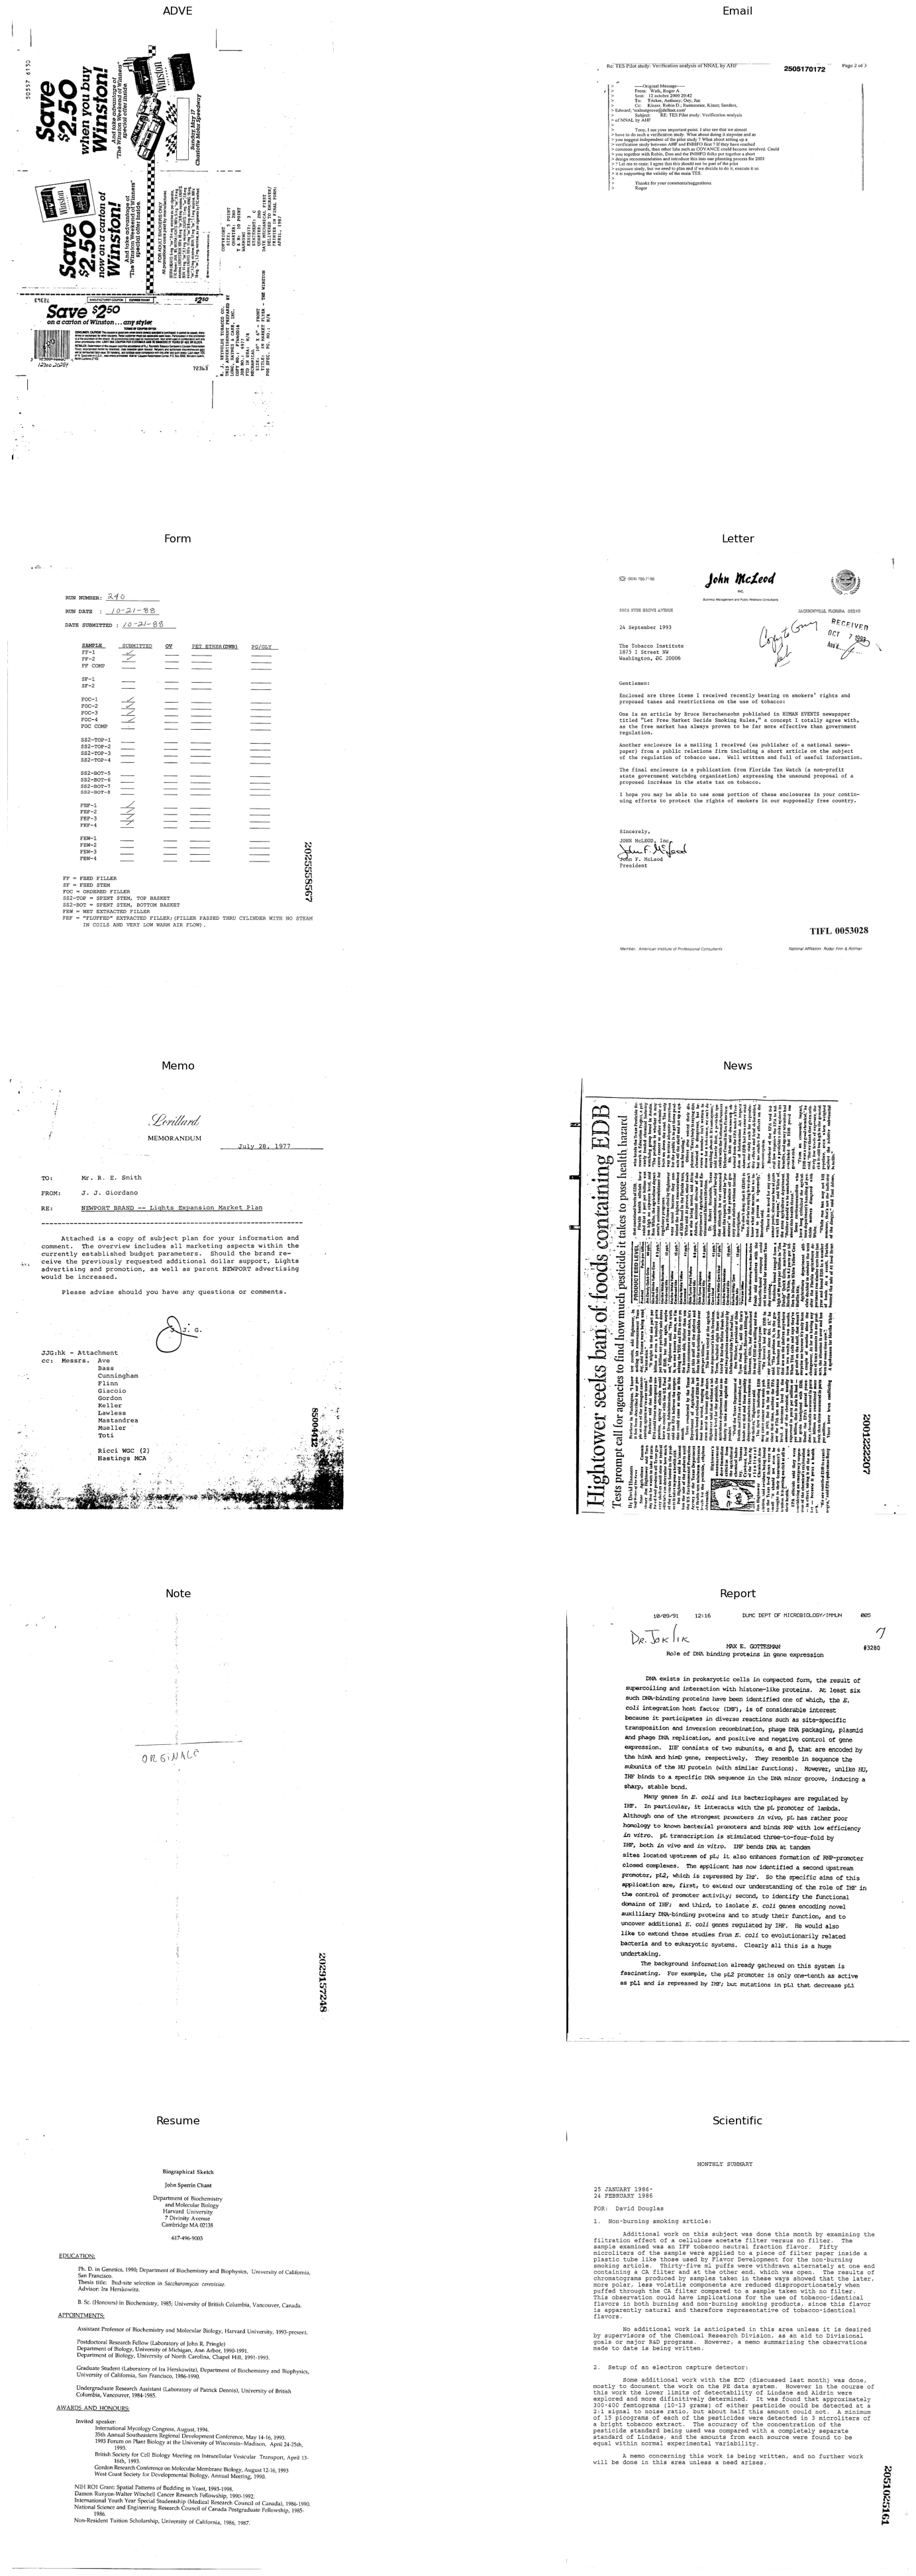

In [4]:
def plot_images(path):
    plt.figure(figsize=(20,50))
    for idx, label in enumerate(os.listdir(path)):
        label_path = os.path.join(path, label)
        images = os.listdir(label_path)
        
        plt.subplot(5,2,idx+1)
        k = np.random.randint(0, len(images))
        im = Image.open(os.path.join(label_path, images[k]))
        plt.imshow(im, cmap='gray')
        plt.axis('off')
        plt.title(label)
        
    plt.show()
        
plot_images(dataset_path)

In [5]:
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
print(label2id)

{'ADVE': 0, 'Email': 1, 'Form': 2, 'Letter': 3, 'Memo': 4, 'News': 5, 'Note': 6, 'Report': 7, 'Resume': 8, 'Scientific': 9}


In [6]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
    if label_folder != dataset_path:
        label = label_folder.split("\\")[-1]
        for _, _, image_names in os.walk(label_folder):
            relative_image_names = []
            for image_file in image_names:
                relative_image_names.append(
                    dataset_path + "/" + label + "/" + image_file)
            images.extend(relative_image_names)
            labels.extend([label] * len(relative_image_names))

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})

labels = list(set(labels))
data.head()

,image_path,label
0,C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/To...,ADVE
1,C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/To...,ADVE
2,C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/To...,ADVE
3,C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/To...,ADVE
4,C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/To...,ADVE


In [7]:
data.shape

(3492, 2)

In [8]:
print("\n[INFO] Checking Dataset..")
c = 0
for index, row in data.iterrows():
    im_path, label = row
    try:
        im = Image.open(im_path).convert("RGB")
    except Exception as e:
        print(e)
        c += 1
        data.drop(index, inplace=True)
        
print(f"done found {c} corrupt images\n")


[INFO] Checking Dataset..
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/ADVE/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Email/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Form/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Letter/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Memo/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/News/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Note/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Report/Thumbs.db'
cannot identify image file 'C:/Users/pawvaibh/Downloads/Tobacco3482-jpg/Tobacco3482-jpg/Resume/Thumbs.db'
cannot identify image file 'C:

In [9]:
train_df, test_df = train_test_split(data, test_size=test_size)

print(f"Train Len:: {len(train_df)}\tTest Len:: {len(test_df)}")

Train Len:: 2785	Test Len:: 697


In [10]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [11]:
feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer1 = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer1)


features = Features({
    'image': Array3D(dtype="int64", shape=(ch, input_size, input_size)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

C:\Users\pawvaibh\AppData\Local\anaconda3\Lib\site-packages\transformers\models\layoutlmv2\feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [12]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "C:/Users/pawvaibh/AppData/Local/Programs/Tesseract-OCR/tesseract.exe"
def preprocess_data(examples):
    print("Starting preprocessing...")
    images = [Image.open(path).convert("RGB")
              for path in examples['image_path']]
    print("Images loaded successfully.")
    encoded_inputs = processor(images, padding="max_length", truncation=True)
    print("Encoded inputs generated.")

    encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]
    print("Labels added.")

    return encoded_inputs




In [14]:
print("\nEncoding Dataset")
train_encoded_data = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names, 
                                       features=features, batched=True, batch_size=2)


Encoding Dataset


Map:   0%|          | 0/2785 [00:00<?, ? examples/s]

In [15]:
train_encoded_data.set_format(type="torch", device=device)